In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.panel import PanelOLS

In [2]:
df = pd.read_excel('Data Finale_balanced_withMinimumWage.xlsx')
df.head()

,Country,Year,Monthly Minimum Wage,CollectiveBargain_Coverage,TradeUnions_Density,Real Average Annual Wage Growth,Annual Inflation CPI,Gini Index,Employment/population ratio Women age 15 to 64,Labour force participation rate (Women age 15 to 64),...,"Children out of school, primary",Current health expenditure (% of GDP),Exports of goods and services (annual % growth),"Foreign direct investment, net inflows (% of GDP)","Foreign direct investment, net outflows (% of GDP)",Imports of goods and services (% of GDP),"Labor force, total",Labor tax and contributions (% of commercial profits),"Part time employment, total (% of total employment)",GDP (current US$)
0,Austria,1990,0.0,98.0,46.8,3.13,3.26,30.8,NaN,61.32,...,4616,9.2,8.57,0.39,1.02,35.79,3569407,35.3,20.4,1.664634e+11
1,Austria,1991,0.0,98.0,45.5,3.13,3.34,30.8,NaN,61.32,...,4616,9.2,2.94,0.21,0.74,35.46,3569407,35.3,20.4,1.737942e+11
2,Austria,1992,0.0,98.0,44.5,2.01,4.02,30.8,NaN,61.32,...,4616,9.2,1.32,0.76,0.90,34.47,3652067,35.3,20.4,1.950781e+11
3,Austria,1993,0.0,98.0,44.0,0.82,3.63,30.8,NaN,61.32,...,4616,9.2,-2.37,0.59,0.62,31.80,3684501,35.3,20.4,1.903797e+11
4,Austria,1994,0.0,98.0,41.5,1.01,2.95,30.8,NaN,61.32,...,4616,9.2,5.69,1.02,0.61,33.83,3851283,35.3,20.4,2.035352e+11


In [3]:
df.rename(columns={
    "Labor force, total": "Labor_force",
    "GDP (current US$)": "GDP",
    "Annual Inflation CPI": "Inflation",
    "Real Average Annual Wage Growth": "WageGrowth",
    "Labour force participation rate (Women age 15 to 64)": "Female_Workers",
    "Trade unions density": "TradeUnions_Density",
    "Central government debt, total (% of GDP)": "Gov_debt",
    "Unemployment rate (Women age 15 to 64)": "WomenUnemployment_rate",
    "Current health expenditure (% of GDP)": "Health_expenditure",
    "Exports of goods and services (annual % growth)": "Exports_growth",
    "Imports of goods and services (% of GDP)": "Imports_growth",
    "Foreign direct investment, net inflows (% of GDP)": "FDI_inflow",
    "Foreign direct investment, net outflows (% of GDP)": "FDI_outflow",
    "Labor tax and contributions (% of commercial profits)": "Tax_contribution",
    "Part time employment, total (% of total employment)": "Parttime_employment"
}, inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['Employment/population ratio Women age 15 to 64'], inplace=True)
print(df.columns)

Index(['index', 'Country', 'Year', 'Monthly Minimum Wage',
       'CollectiveBargain_Coverage', 'TradeUnions_Density', 'WageGrowth',
       'Inflation', 'Gini Index', 'Female_Workers', 'WomenUnemployment_rate',
       'Gov_debt', 'Children out of school, primary', 'Health_expenditure',
       'Exports_growth', 'FDI_inflow', 'FDI_outflow', 'Imports_growth',
       'Labor_force', 'Tax_contribution', 'Parttime_employment', 'GDP'],
      dtype='object')


## Variable engineering

In [4]:
df['lnGDP'] = np.log(df['GDP'])
df['lnGDP'].round(2)
df['minwage'] = (df['Monthly Minimum Wage'] > 0).any()
df['minwage'] = df['minwage'].astype(int)

# Data Visualisation

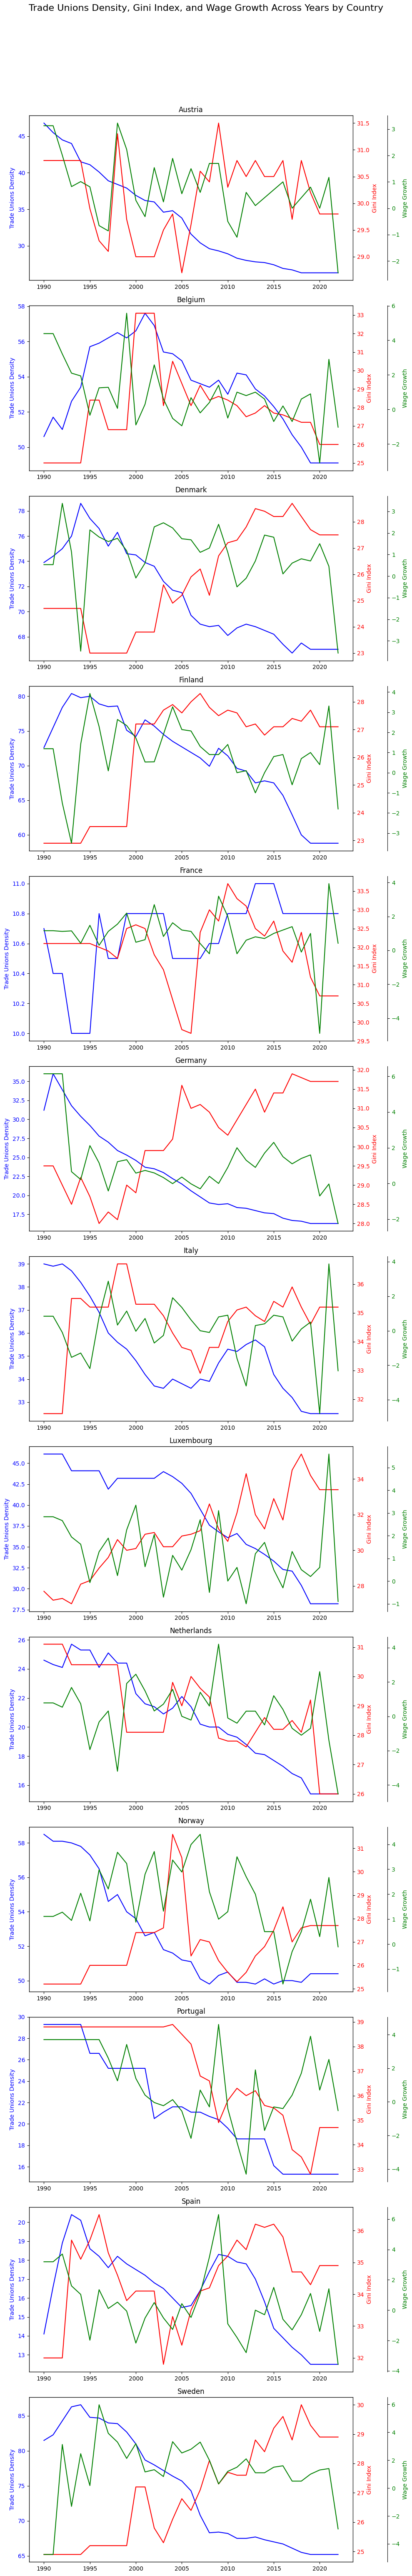

In [5]:
countries = df['Country'].unique()

fig, axs = plt.subplots(len(countries), 1, figsize=(10, 5 * len(countries)))

if len(countries) == 1:
    axs = [axs]

for ax, country in zip(axs, countries):
    data = df[df['Country'] == country]

    ax.plot(data['Year'], data['TradeUnions_Density'], color='blue', label='Trade Unions Density')
    ax.set_ylabel('Trade Unions Density', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    
    ax2 = ax.twinx()
    ax2.plot(data['Year'], data['Gini Index'], color='red', label='Gini Index')
    ax2.set_ylabel('Gini Index', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    ax3 = ax.twinx()
    ax3.spines['right'].set_position(('outward', 60))  
    ax3.plot(data['Year'], data['WageGrowth'], color='green', label='Wage Growth')
    ax3.set_ylabel('Wage Growth', color='green')
    ax3.tick_params(axis='y', labelcolor='green')
    
    ax.set_title(country)

plt.suptitle('Trade Unions Density, Gini Index, and Wage Growth Across Years by Country', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Correlation Matrix

/Users/jacopobinati/opt/miniconda3/lib/python3.9/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


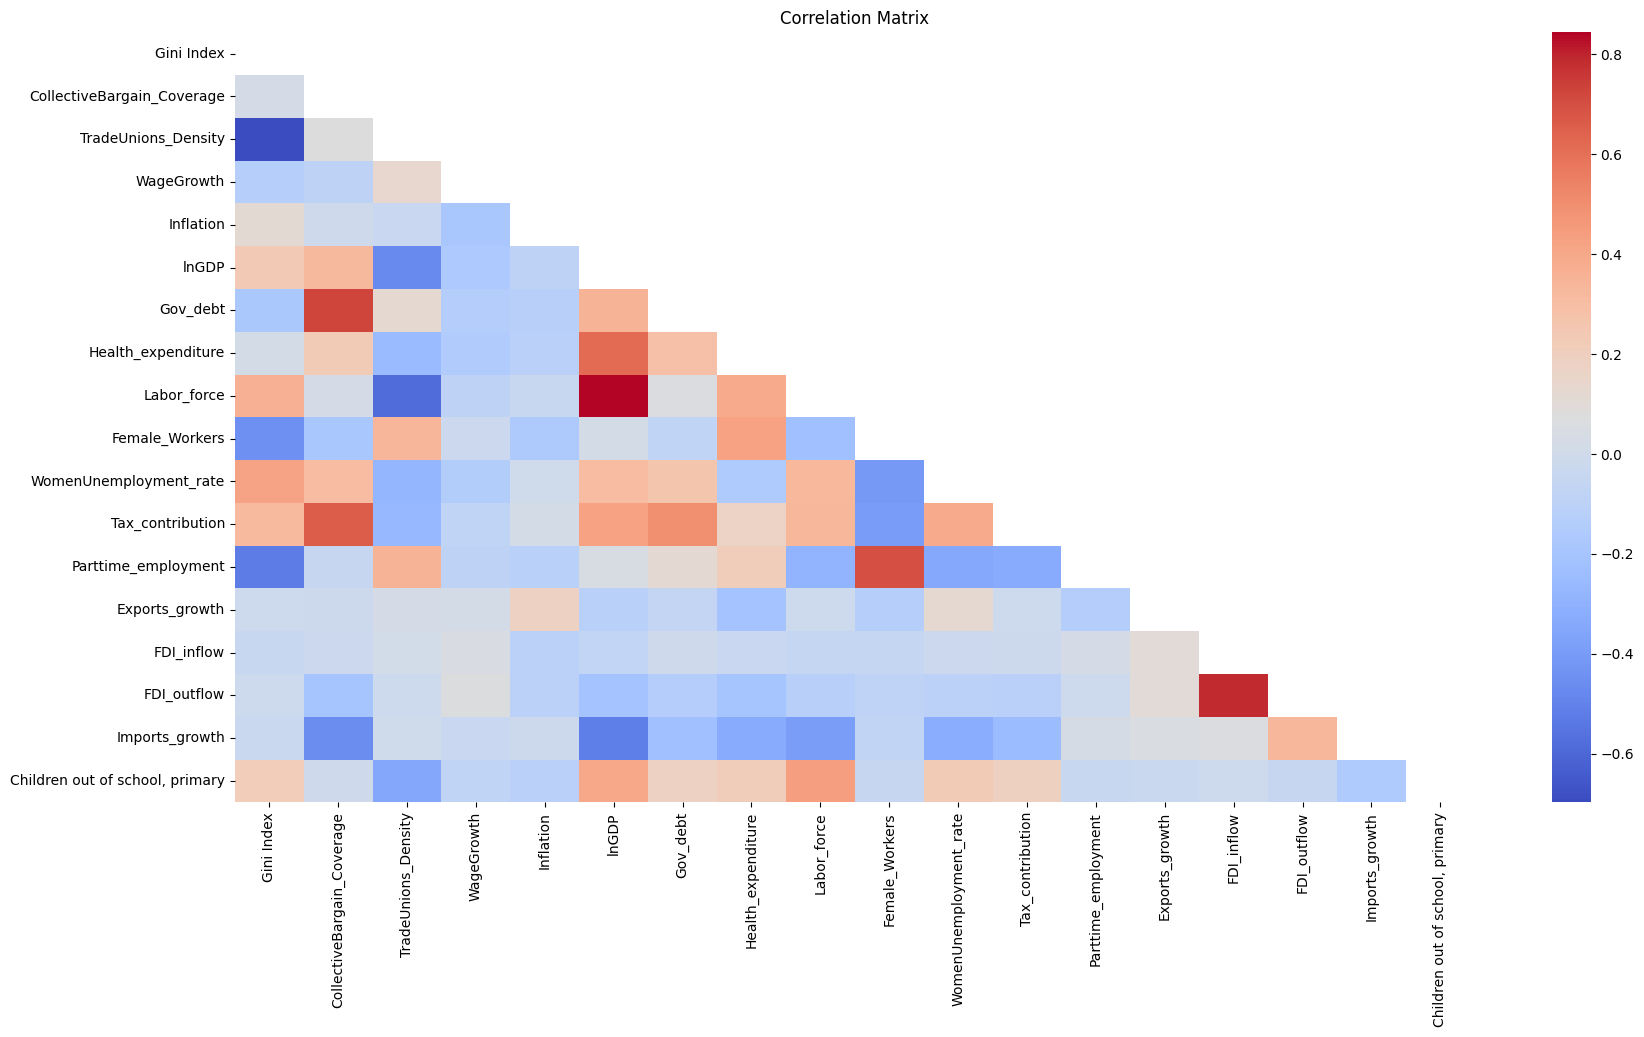

In [6]:
variables = ['Gini Index', 'CollectiveBargain_Coverage', 'TradeUnions_Density', 'WageGrowth',
             'Inflation', 'lnGDP', 'Gov_debt', 'Health_expenditure',
             'Labor_force', 'Female_Workers', 'WomenUnemployment_rate',
             'Tax_contribution', 'Parttime_employment',
             'Exports_growth', 'FDI_inflow', 'FDI_outflow', 'Imports_growth',
             'Children out of school, primary']
df_small = df[variables]
corr_matrix = df_small.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8})
plt.title('Correlation Matrix')
plt.show()

# Relation between Coverage and Density over time

In [7]:
countries = df['Country'].unique()

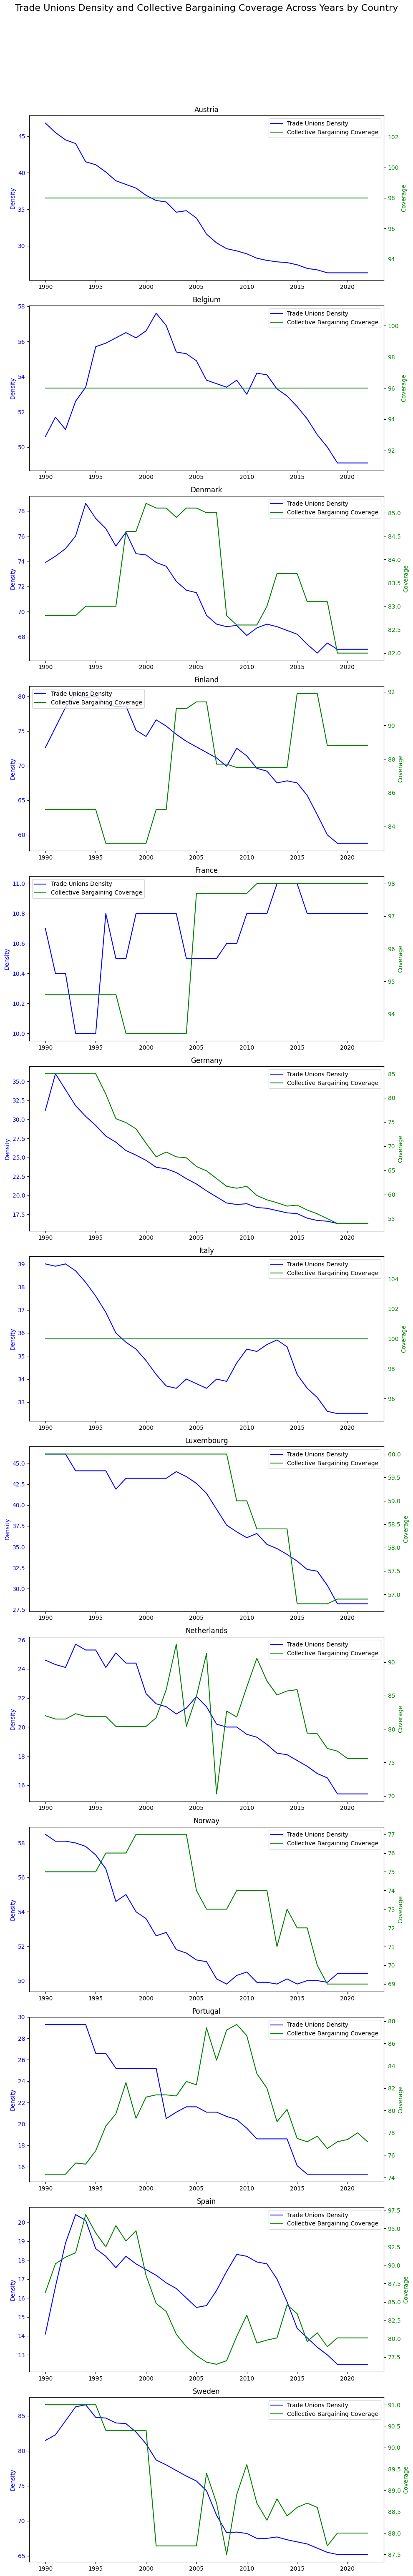

In [8]:
fig, axs = plt.subplots(len(countries), 1, figsize=(10, 5 * len(countries)), squeeze=False)  # Ensuring axs is always a 2D array

for ax, country in zip(axs.flatten(), countries):  # Use flatten() to iterate correctly over axs
    data = df[df['Country'] == country]

    # Plotting Trade Unions Density
    ax.plot(data['Year'], data['TradeUnions_Density'], color='blue', label='Trade Unions Density')
    ax.set_ylabel('Density', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')

    # Plotting Collective Bargaining Coverage on a secondary y-axis
    ax2 = ax.twinx()
    ax2.plot(data['Year'], data['CollectiveBargain_Coverage'], color='green', label='Collective Bargaining Coverage')
    ax2.set_ylabel('Coverage', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    
    # Adding a legend to each subplot for clarity
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')
    
    ax.set_title(country)

plt.suptitle('Trade Unions Density and Collective Bargaining Coverage Across Years by Country', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
plt.show()

## Regression

In [9]:
# Define your independent variables for each regression
model1 = ['CollectiveBargain_Coverage', 'Inflation', 'WageGrowth', 'minwage']
model2 = ['CollectiveBargain_Coverage', 'Inflation', 'WageGrowth', 'minwage', 'TradeUnions_Density']
model3 = ['CollectiveBargain_Coverage', 'Inflation', 'WageGrowth', 'minwage', 'TradeUnions_Density', 'lnGDP', 'Gov_debt', 'Health_expenditure']
model4 = ['CollectiveBargain_Coverage', 'Inflation', 'WageGrowth', 'minwage', 'TradeUnions_Density', 'lnGDP', 'Gov_debt', 'Health_expenditure', 'Labor_force', 'Female_Workers', 'Parttime_employment', 'WomenUnemployment_rate']
model5 = ['CollectiveBargain_Coverage', 'Inflation', 'WageGrowth', 'minwage', 'TradeUnions_Density', 'lnGDP', 'Gov_debt', 'Health_expenditure', 'Labor_force', 'Female_Workers', 'Parttime_employment', 'WomenUnemployment_rate', 'Exports_growth', 'Imports_growth']
model6 = ['CollectiveBargain_Coverage', 'Inflation', 'WageGrowth', 'minwage', 'TradeUnions_Density', 'lnGDP', 'Gov_debt', 'Health_expenditure', 'Labor_force', 'Female_Workers', 'Parttime_employment', 'WomenUnemployment_rate', 'Exports_growth', 'Imports_growth', 'FDI_inflow', 'FDI_outflow', 'Tax_contribution']

# List of all independent variables
modelli = [model1, model2, model3, model4, model5, model6]


In [10]:
# Define the order of the variables
regressor_order = ['CollectiveBargain_Coverage', 'Inflation', 'WageGrowth', 'minwage', 'TradeUnions_Density', 'lnGDP', 'Gov_debt', 'Health_expenditure']

# List to store models
models = []

# Run each regression
for i, independent_vars in enumerate(modelli, start=1):
    X = sm.add_constant(df[independent_vars])  # Add a constant to the independent variables
    y = df['Gini Index']

    model = sm.OLS(y, X).fit()
    models.append(model)

# Create a summary table of all models
summary_table = summary_col(models, stars=True, float_format='%0.2f',
                            model_names=['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5','Model 6'],
                            info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                                       'R2':lambda x: "{:.2f}".format(x.rsquared)},
                            regressor_order=regressor_order)
summary_table

,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6
CollectiveBargain_Coverage,0.00,0.02**,0.09***,0.03*,0.05**,0.03
,(0.01),(0.01),(0.01),(0.02),(0.02),(0.02)
Inflation,0.19*,0.18**,0.06,0.03,0.07,0.06
,(0.10),(0.07),(0.07),(0.06),(0.06),(0.06)
WageGrowth,-0.24**,-0.02,-0.13*,-0.14**,-0.11,-0.12*
,(0.11),(0.08),(0.07),(0.07),(0.07),(0.07)
minwage,29.61***,32.65***,34.63***,16.11**,15.79**,17.59**
,(1.28),(0.93),(3.81),(7.69),(7.91),(7.98)
TradeUnions_Density,,-0.12***,-0.13***,-0.09***,-0.09***,-0.09***
,,(0.01),(0.01),(0.01),(0.01),(0.01)


## Fixed Effects on Years and Country


In [11]:
if 'Country' in df.columns and 'Year' in df.columns:
    df = df.set_index(['Country', 'Year'])
models_results = []

for i, independent_vars in enumerate(modelli, start=1):
    X = df[independent_vars]
    y = df['Gini Index']
    X = sm.add_constant(X)

    model = PanelOLS(y, X, entity_effects=True, time_effects=True).fit()
    models_results.append(model)

In [12]:
summary_data = []

for i, result in enumerate(models_results, start=1):
    # Basic statistics
    r2 = result.rsquared
    n = result.nobs
    model_name = f"Model {i}"
    
    for var in result.params.index:
        coef = result.params[var]
        std_err = result.std_errors[var]
        summary_data.append({
            'Model': model_name,
            'Variable': var,
            'Coefficient': coef,
            'Std. Error': std_err,
            'R-squared': r2,
            'Observations': n
        })

summary_df = pd.DataFrame(summary_data)
summary_pivot = summary_df.pivot(index='Variable', columns='Model', values=['Coefficient', 'Std. Error', 'R-squared', 'Observations'])
summary_pivot

Coefficient                                      
Model                          Model 1    Model 2   Model 3       Model 4   
Variable                                                                    
CollectiveBargain_Coverage   -0.017838  -0.012795 -0.016985 -3.720857e-02  \
Exports_growth                     NaN        NaN       NaN           NaN   
FDI_inflow                         NaN        NaN       NaN           NaN   
FDI_outflow                        NaN        NaN       NaN           NaN   
Female_Workers                     NaN        NaN       NaN -1.459505e-01   
Gov_debt                           NaN        NaN  0.004489  2.030827e-03   
Health_expenditure                 NaN        NaN  0.041640 -2.718156e-02   
Imports_growth                     NaN        NaN       NaN           NaN   
Inflation                     0.182398   0.187647  0.173991  1.761771e-01   
Labor_force                        NaN        NaN       NaN  2.489278e-07   
Parttime_employment                NaN        NaN       NaN  2.208991e-02   
Tax_contribution                   NaN        NaN       NaN           NaN   
TradeUnions_Density                NaN  -0.074696 -0.073371 -4.916960e-02   
WageGrowth                    0.024344   0.026773  0.018994 -3.064047e-04   
WomenUnemployment_rate             NaN        NaN       NaN  8.871623e-02   
lnGDP                              NaN        NaN  1.043618  2.352315e+00   
minwage                      31.224553  33.781568  5.532560 -2.285745e+01   

                                                       Std. Error             
Model                            Model 5       Model 6    Model 1   Model 2   
Variable                                                                      
CollectiveBargain_Coverage -2.310025e-02 -3.359571e-02   0.019818  0.019752  \
Exports_growth             -4.667361e-02 -4.522555e-02        NaN       NaN   
FDI_inflow                           NaN -4.206905e-03        NaN       NaN   
FDI_outflow                          NaN  3.807956e-03        NaN       NaN   
Female_Workers             -2.578496e-01 -2.561321e-01        NaN       NaN   
Gov_debt                    2.389883e-03  3.870814e-03        NaN       NaN   
Health_expenditure          3.949817e-01  4.169740e-01        NaN       NaN   
Imports_growth              1.046299e-01  1.042026e-01        NaN       NaN   
Inflation                   3.351008e-02  3.431539e-02   0.074297  0.073736   
Labor_force                 5.566255e-07  5.164977e-07        NaN       NaN   
Parttime_employment         3.367170e-02  3.059698e-02        NaN       NaN   
Tax_contribution                     NaN -7.962590e-02        NaN       NaN   
TradeUnions_Density        -4.459523e-02 -3.404863e-02        NaN  0.028033   
WageGrowth                 -4.881763e-02 -5.435254e-02   0.053512  0.053096   
WomenUnemployment_rate      7.211293e-02  7.785781e-02        NaN       NaN   
lnGDP                       1.383374e+00  1.539862e+00        NaN       NaN   
minwage                    -2.749563e+00 -4.016871e+00   1.695259  1.936359   

                                                     ... R-squared             
Model                         Model 3       Model 4  ...   Model 3   Model 4   
Variable                                             ...                       
CollectiveBargain_Coverage   0.020035  2.375213e-02  ...  0.042019  0.103901  \
Exports_growth                    NaN           NaN  ...       NaN       NaN   
FDI_inflow                        NaN           NaN  ...       NaN       NaN   
FDI_outflow                       NaN           NaN  ...       NaN       NaN   
Female_Workers                    NaN  3.306822e-02  ...       NaN  0.103901   
Gov_debt                     0.006788  7.385994e-03  ...  0.042019  0.103901   
Health_expenditure           0.154853  1.666676e-01  ...  0.042019  0.103901   
Imports_growth                    NaN           NaN  ...       NaN       NaN   
Inflation                

check the correlation cross countries. and plot graphs for each countries. write doe the reason behind the varibales